`Work was done 04.12.2019`

### О чём
В теоретической части выведен градиент функции потерь, который нас интересует при реализации логистической регрессии.

В модулях `optimization.py, oracles.py, utils.py` находится реализация логистической регрессии и методов обучения с помощью градиентного спуска и стохастического градиентного спуска.

В ноутбуке дальше проведены некоторые эксперименты по датасету с текстами и анализ выполненной имплементации.

### Теоретическая часть

Хотим: $$Q(x, w) = \frac{1}{l}\sum\limits_{i=1}^l \ln (1 + e^{-y_iw^Tx_i}) + \frac{\lambda}{2}||w||_2^2 \rightarrow \min_w$$
То есть посчитаем градиент функционала

Решение:
(сейчас будут пояснения чисто для себя)

$$
||w||_2^2 = w_0^2 + w_1^2 + \ldots + w_n^2 \\
x_i = (1\;x_1^i\; x_2^i \;\ldots\; x_n^i)^T \text{    i-й объект выборки с n признаками} \\
w = (w_0\; w_1\; \ldots \;w_n)^T
$$

Введем поэлементные операции (чтобы было проще понять, что к чему) и посмотрим, чему равны частные производные наших слагаемых в исходной функции.

$$\frac{\partial \ln (1 + e^{-yw^Tx})}{\partial w_i} = \frac{\partial \ln (1 + e^{-y(w_0x_0 + w_1x_1 + \ldots + w_ix_i + \ldots + w_nx_n)})}{\partial w_i} = \frac{1}{1 + e^{-y(w_0x_0 + w_1x_1 + \ldots + w_ix_i + \ldots + w_nx_n)}} \times \left(e^{-y(w_0x_0 + w_1x_1 + \ldots + w_ix_i + \ldots + w_nx_n)}\right) \times (-yx_i)$$

Тогда имеем следующий градиент: 
$$
\nabla \ln (1 + e^{-y_iw^Tx_i}) = \frac{e^{-y_iw^Tx_i}}{1 + e^{-y_iw^Tx_i}} \times (-y_ix_i) = \frac{-y_ix_i}{1 + e^{y_iw^Tx_i}}
$$ 

Для нормы имеем следующий градиент: $$
\nabla ||w||_2^2 = 2w
$$

Соберем всё вместе и получим искомый градиент:
$$
\nabla Q(x, w) = \frac{1}{l} \sum\limits_{i=1}^l \left(\frac{-y_ix_i}{1 + e^{y_iw^Tx_i}}\right) + \lambda w
$$

P.S. Надеюсь с размерностями ничего не напутал, но вроде всё в порядке :)

In [1]:
import optimization
import oracles
import utils
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

Для начала убедимся, что модель построена правильно, проверив её на игрушечном примере

In [2]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

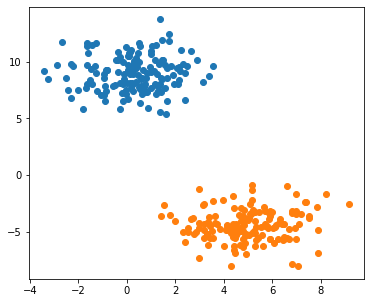

In [3]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

In [4]:
model1 = optimization.GDClassifier(loss_function='binary_logistic', step_alpha=1,
                                   step_beta=0, tolerance=1e-4,
                                   max_iter=100, l2_coef=0.1)
model2 = optimization.SGDClassifier(loss_function='binary_logistic', step_alpha=1,
                                   step_beta=0, tolerance=1e-4,
                                   max_iter=100, l2_coef=0.1, batch_size=30)
model1.fit(X, y)
model2.fit(X, y)

In [5]:
y_pred = model1.predict(X)

In [6]:
y_pred = np.where(y_pred==-1, 0, y_pred).astype(int)

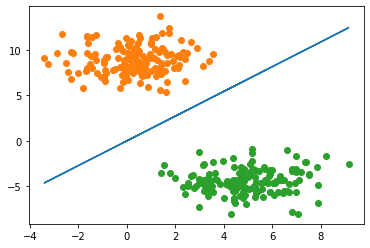

In [7]:
x_values = X[:, 0]
y_values = - (x_values * model1.w[0]) / model1.w[1]
# ax + by = 0 by = -ax; y = -ax/b
plt.plot(x_values, y_values, label='Decision Boundary')
#plot_data(X, y_pred)
for i in range(2):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

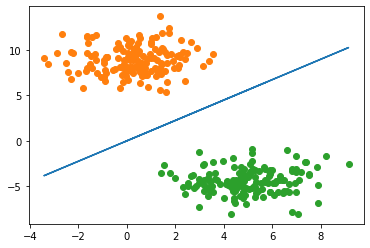

In [8]:
x_values = X[:, 0]
y_values = - (x_values * model2.w[0]) / model2.w[1]
# ax + by = 0 by = -ax; y = -ax/b
plt.plot(x_values, y_values, label='Decision Boundary')
#plot_data(X, y_pred)
for i in range(2):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Перейдем к основным экспериментам

In [9]:
train = pd.read_csv('toxic_train.csv')
test = pd.read_csv('toxic_test.csv')

In [10]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)
train.replace([True, False], [1, -1], inplace=True)
test.replace([True, False], [1, -1], inplace=True)

In [11]:
test.head()

,comment_text,is_toxic
0,Thank you for understanding. I think very high...,-1
1,:Dear god this site is horrible.,-1
2,"""::: Somebody will invariably try to add Relig...",-1
3,""" \n\n It says it right there that it IS a typ...",-1
4,""" \n\n == Before adding a new product to the l...",-1


In [12]:
train.head()

,comment_text,is_toxic
0,Explanation\nWhy the edits made under my usern...,-1
1,D'aww! He matches this background colour I'm s...,-1
2,"Hey man, I'm really not trying to edit war. It...",-1
3,"""\nMore\nI can't make any real suggestions on ...",-1
4,"You, sir, are my hero. Any chance you remember...",-1


In [13]:
import re

In [14]:
train['comment_text'] = train['comment_text'].apply(str.lower)
test['comment_text'] = test['comment_text'].apply(str.lower)

In [15]:
def clear(s):
    s = re.sub('\n', ' ', s)
    s = re.sub('[^a-z\s]', '', s)
    return s

In [16]:
train['comment_text'] = train['comment_text'].apply(clear)
test['comment_text'] = test['comment_text'].apply(clear)

In [17]:
train.head()

,comment_text,is_toxic
0,explanation why the edits made under my userna...,-1
1,daww he matches this background colour im seem...,-1
2,hey man im really not trying to edit war its j...,-1
3,more i cant make any real suggestions on impr...,-1
4,you sir are my hero any chance you remember wh...,-1


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
vectorizer = CountVectorizer(min_df=0.1, max_df=0.9)
X_train = vectorizer.fit_transform(train.iloc[:, 0])
X_test = vectorizer.transform(test.iloc[:, 0])

In [20]:
from scipy.sparse import hstack

In [21]:
X_train = hstack((X_train, np.ones(X_train.shape[0])[:, None]), format='csr')
X_test = hstack((X_test, np.ones(X_test.shape[0])[:, None]), format='csr')

In [22]:
y_train = train.is_toxic
y_test = test.is_toxic

Посмотрим на поведение градиентного спускав зависимости от step_alpha

In [23]:
func_data = []
time_data = []
for i in range(10):
    step_alpha=i+1
    model_gdc = optimization.GDClassifier(l2_coef=0.1, step_alpha=step_alpha, step_beta=1)
    history = model_gdc.fit(X_train, y_train, trace=True)
    func_data.append(history['func'])
    time_data.append(np.cumsum(history['time']))

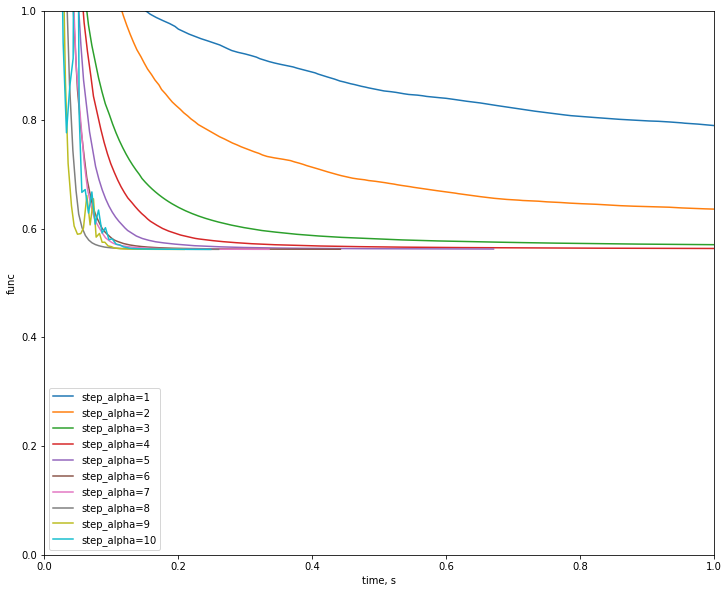

In [24]:
plt.figure(figsize=(12, 10))
plt.xlabel('time, s')
plt.ylabel('func')
for i in range(10):
    plt.plot(time_data[i], func_data[i], scalex=False, scaley=False, label=f'step_alpha={i+1}')
plt.legend(loc='lower left')

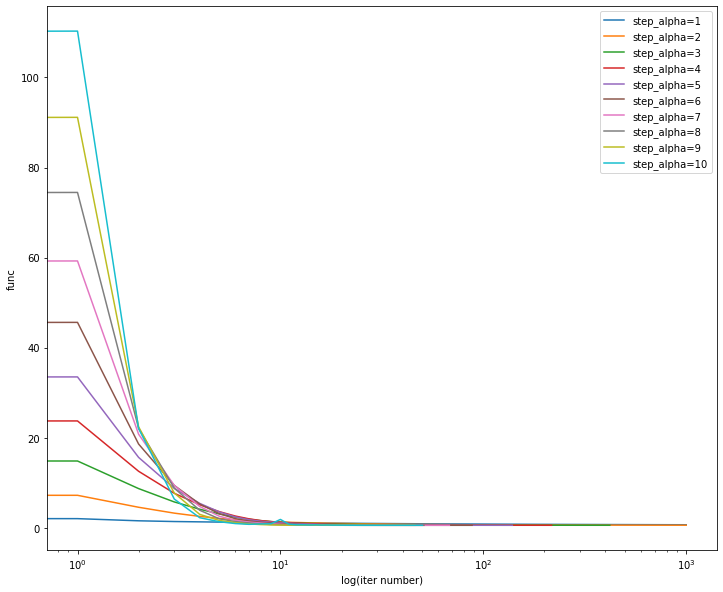

In [25]:
plt.figure(figsize=(12, 10))
plt.xlabel('log(iter number)')
plt.ylabel('func')
plt.xscale('log')
#plt.yscale('log')
for i in range(10):
    iters = np.arange(len(func_data[i]))
    plt.plot(iters, func_data[i], scalex=True, scaley=True, label=f'step_alpha={i+1}')
plt.legend(loc='upper right')

Посмотрим на поведение в зависимость от step_beta

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
func_data = []
time_data = []
accuracy_data = []
for i in range(10):
    step_beta=i
    model_gdc = optimization.GDClassifier(l2_coef=0.1, step_alpha=5, step_beta=step_beta)
    history = model_gdc.fit(X_train, y_train, trace=True)
    y_pred = model_gdc.predict(X_test)
    accuracy_data.append(accuracy_score(y_pred, y_test))
    func_data.append(history['func'])
    time_data.append(np.cumsum(history['time']))

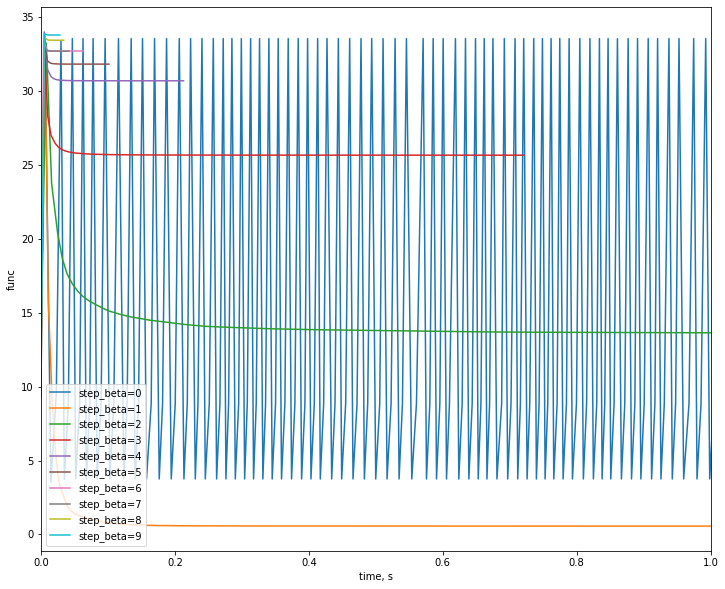

In [28]:
plt.figure(figsize=(12, 10))
plt.xlabel('time, s')
plt.ylabel('func')
for i in range(10):
    plt.plot(time_data[i], func_data[i], scalex=False, scaley=True, label=f'step_beta={i}')
plt.legend(loc='lower left')

Прокомментирую график: изначально взят довольно большой step_alpha поэтому при step_beta = 0 градиент прыгает туда сюда, при step_beta > 1 слишком сильно уменьшает коэффициент при градиенте и его не хватает, чтобы достичь минимума и step_beta = 1 является оптимальным

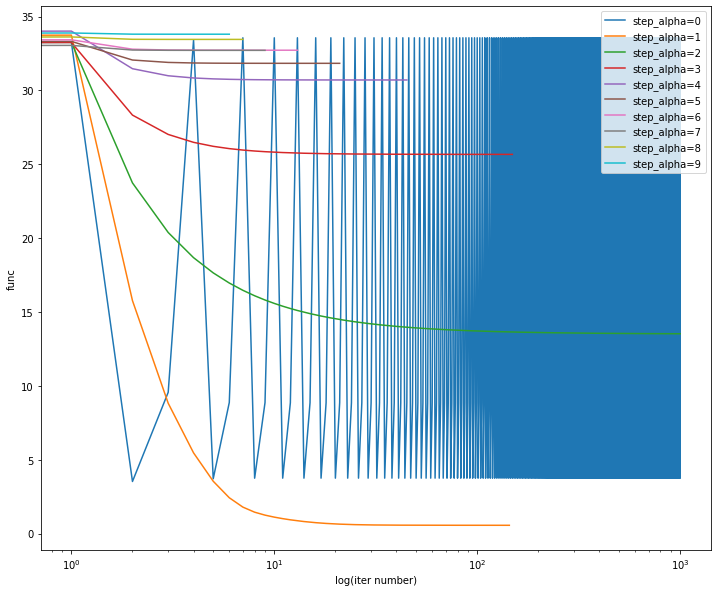

In [29]:
plt.figure(figsize=(12, 10))
plt.xlabel('log(iter number)')
plt.ylabel('func')
plt.xscale('log')
#plt.yscale('log')
for i in range(10):
    iters = np.arange(len(func_data[i]))
    plt.plot(iters, func_data[i], scalex=True, scaley=True, label=f'step_alpha={i}')
plt.legend(loc='upper right')

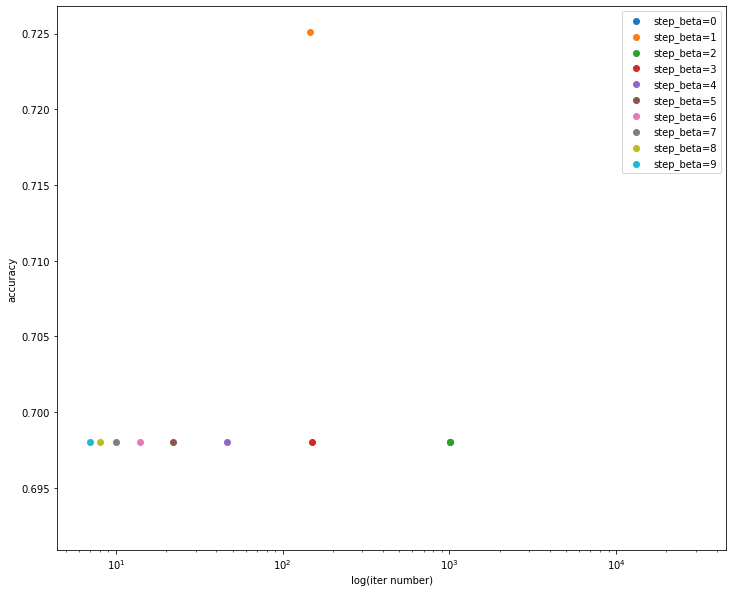

In [30]:
plt.figure(figsize=(12, 10))
plt.xlabel('log(iter number)')
plt.ylabel('accuracy')
plt.xscale('log')
#plt.yscale('log')
for i in range(10):
    plt.scatter(len(func_data[i]), accuracy_data[i], label=f'step_beta={i}')
plt.legend(loc='upper right')

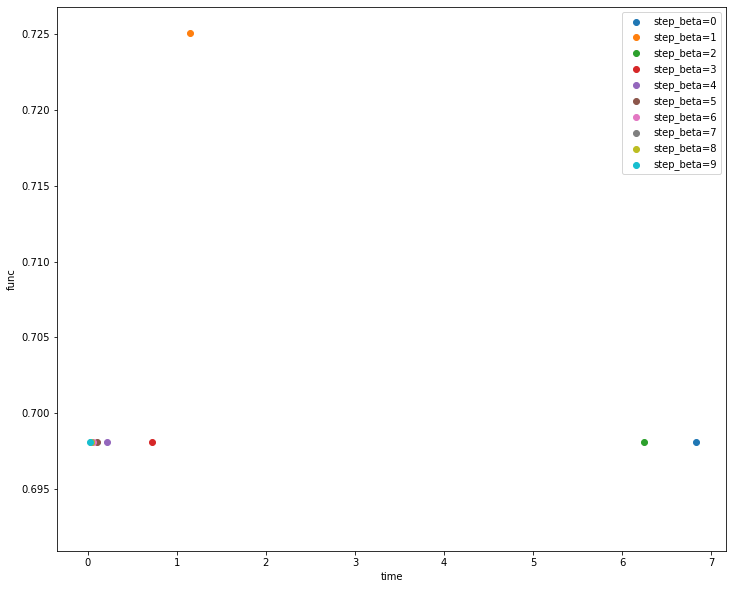

In [31]:
plt.figure(figsize=(12, 10))
plt.xlabel('time')
plt.ylabel('func')
for i in range(10):
    plt.scatter(time_data[i][-1], accuracy_data[i], label=f'step_beta={i}')
plt.legend(loc='upper right')

Выводы по step_beta: слишком много - плохо, т.к. недоходим до минимума, слишком мало - плохо, т.к. перепрыгиваем минимум туда-сюда. Accuracy от времени и количества итераций зависит не сильно - главное дойти до минимума функционала.

Посмотрим зависимость от начального приближения

In [32]:
func_data = []
time_data = []
accuracy_data = []

model_gdc_uniform = optimization.GDClassifier(l2_coef=0.1, step_alpha=5, step_beta=1)
history = model_gdc_uniform.fit(X_train, y_train, trace=True)
y_pred = model_gdc_uniform.predict(X_test)
accuracy_data.append(accuracy_score(y_pred, y_test))
func_data.append(history['func'])
time_data.append(np.cumsum(history['time']))

model_gdc_ones = optimization.GDClassifier(l2_coef=0.1, step_alpha=5, step_beta=1)
history = model_gdc_ones.fit(X_train, y_train, trace=True, w_0=np.ones(X_train.shape[1]))
y_pred = model_gdc_ones.predict(X_test)
accuracy_data.append(accuracy_score(y_pred, y_test))
func_data.append(history['func'])
time_data.append(np.cumsum(history['time']))

model_gdc_big = optimization.GDClassifier(l2_coef=0.1, step_alpha=5, step_beta=1)
history = model_gdc_big.fit(X_train, y_train, trace=True, w_0=np.ones(X_train.shape[1])*10)
y_pred = model_gdc_big.predict(X_test)
accuracy_data.append(accuracy_score(y_pred, y_test))
func_data.append(history['func'])
time_data.append(np.cumsum(history['time']))

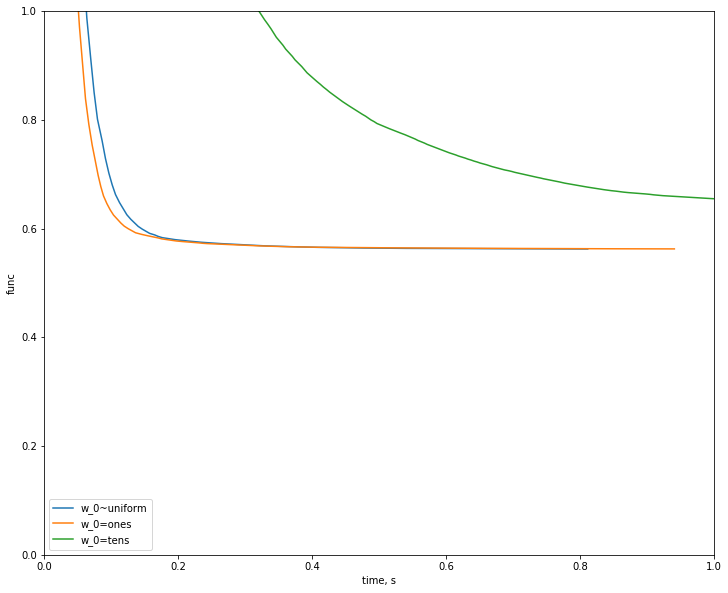

In [33]:
plt.figure(figsize=(12, 10))
plt.xlabel('time, s')
plt.ylabel('func')
plt.plot(time_data[0], func_data[0], scalex=False, scaley=False, label='w_0~uniform')
plt.plot(time_data[1], func_data[1], scalex=False, scaley=False, label='w_0=ones')
plt.plot(time_data[2], func_data[2], scalex=False, scaley=False, label='w_0=tens')
plt.legend(loc='lower left')

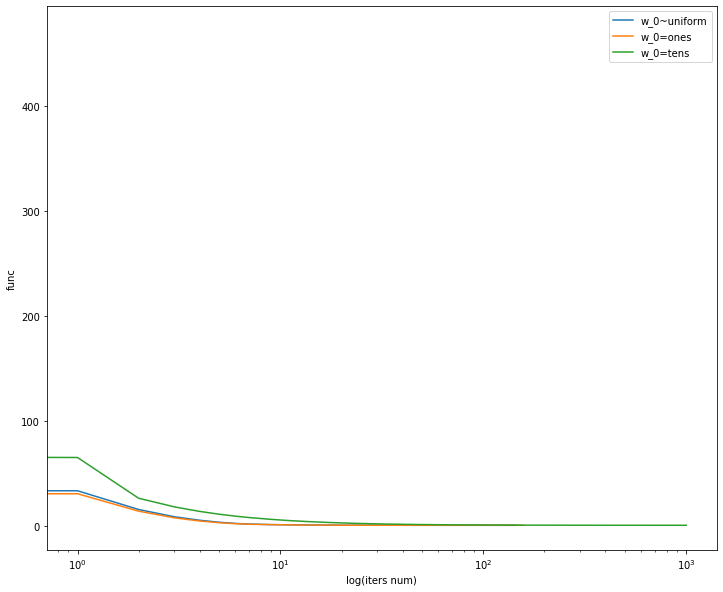

In [34]:
plt.figure(figsize=(12, 10))
plt.xlabel('log(iters num)')
plt.xscale('log')
plt.ylabel('func')
plt.plot(np.arange(len(func_data[0])), func_data[0], label='w_0~uniform')
plt.plot(np.arange(len(func_data[1])), func_data[1], label='w_0=ones')
plt.plot(np.arange(len(func_data[2])), func_data[2], label='w_0=tens')
plt.legend(loc='upper right')

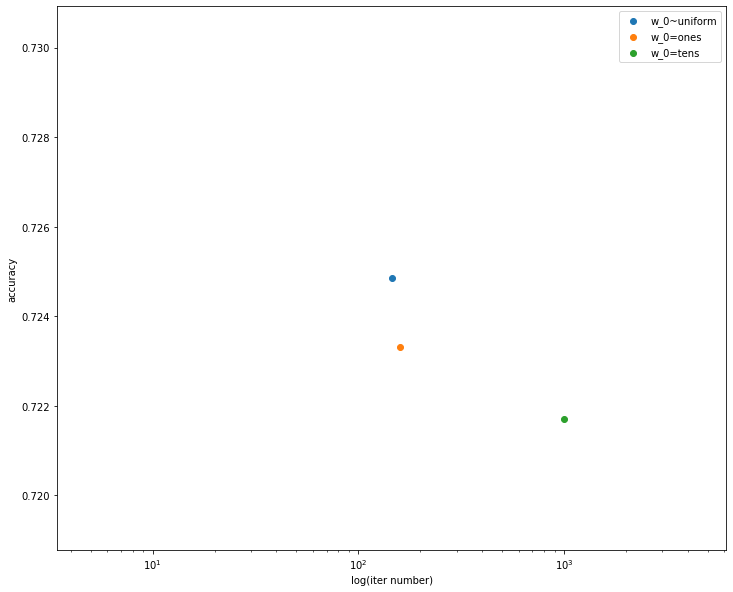

In [35]:
plt.figure(figsize=(12, 10))
plt.xlabel('log(iter number)')
plt.ylabel('accuracy')
plt.xscale('log')
#plt.yscale('log')
plt.scatter(len(func_data[0]), accuracy_data[0], label='w_0~uniform')
plt.scatter(len(func_data[1]), accuracy_data[1], label='w_0=ones')
plt.scatter(len(func_data[2]), accuracy_data[2], label='w_0=tens')
plt.legend(loc='upper right')

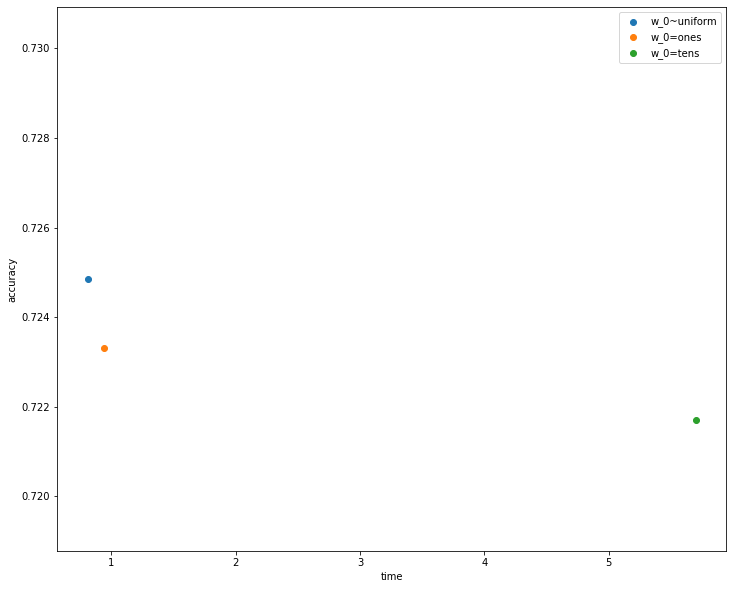

In [36]:
plt.figure(figsize=(12, 10))
plt.xlabel('time')
plt.ylabel('accuracy')
plt.scatter(time_data[0][-1], accuracy_data[0], label='w_0~uniform')
plt.scatter(time_data[1][-1], accuracy_data[1], label='w_0=ones')
plt.scatter(time_data[2][-1], accuracy_data[2], label='w_0=tens')
plt.legend(loc='upper right')

Выводы: слишком большое начальное приближение дает плохие результаты, лучшие результаты наблюдаются при приближении в качестве равномерного распределения

Посмотрим зависимости SGDC. Для начала batch_size

In [37]:
func_data = []
time_data = []
size_koef = (0.1, 0.3, 0.5, 0.8)
for koef in size_koef:
    # 10%, 30%, 50%, 80%
    batch_size = int(koef * X_test.shape[0])
    model_sgdc = optimization.GDClassifier(l2_coef=0.1, step_alpha=5, step_beta=1, batch_size=batch_size)
    history = model_sgdc.fit(X_train, y_train, trace=True)
    func_data.append(history['func'])
    time_data.append(np.cumsum(history['time']))

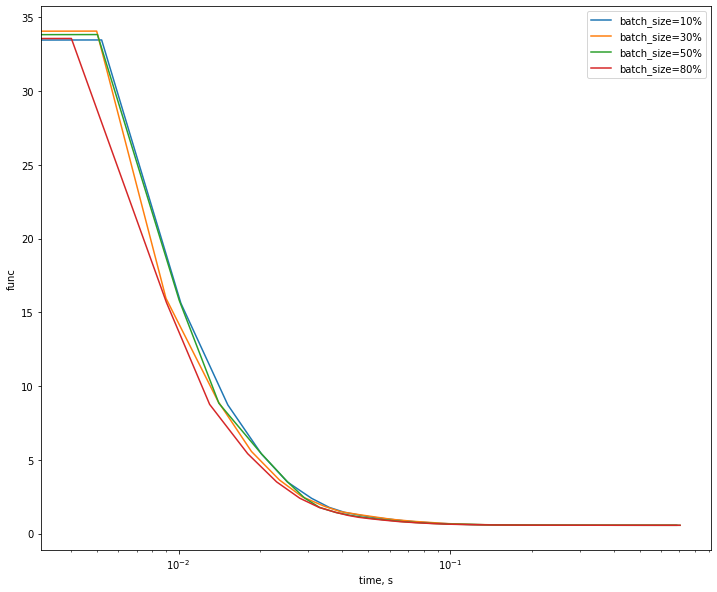

In [38]:
plt.figure(figsize=(12, 10))
plt.xlabel('time, s')
plt.ylabel('func')
plt.xscale('log')
#plt.yscale('log')
for i in range(4):
    plt.plot(time_data[i], func_data[i], label=f'batch_size={int(size_koef[i]*100)}%')
plt.legend(loc='upper right')

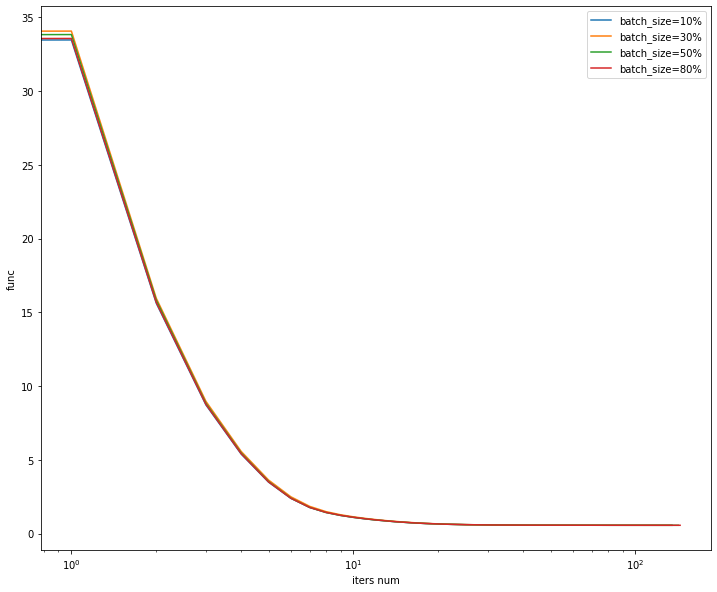

In [39]:
plt.figure(figsize=(12, 10))
plt.xlabel('iters num')
plt.ylabel('func')
plt.xscale('log')
#plt.yscale('log')
for i in range(4):
    plt.plot(np.arange(len(func_data[i])), func_data[i], label=f'batch_size={int(size_koef[i]*100)}%')
plt.legend(loc='upper right')

Выводы по SGDC и сравнение с GDC:

1) работает быстрее

2) требует меньше памяти

3) сходится хорошо даже при маленьком батче

Но: необходимо найти правильный размер батча, так как при слишком большом теряется смысл стохастики, а при слишком маленьком - может плохо и медленно сходится (зависит от частоты обновления)

Также некоторые выводы по поводу параметров min_df и max_df у vectorizer:

Если использовать по умолчанию то, все слова учитываются и размерность пространства становится очень большим, причем сильно разреженным. При этом качество на тесте очень плохое, около 0.55

Если отсеявать слишком редко встречаемые слова с помощью min_df и часто встречаемые с помощью max_df, то качество сильно улучшается, однако тут необходимо правильно подобрать значения (я для себя выбрал 0.1 и 0.9). 